# W266 Russian Troll Detection Project

# LSTM Notebook, Including Metadata

## Quick Status:  Tweet and User Metadata Incorporated; Variable Length LSTM enabled

This notebook takes the output of our Pre-Processing work (embedded tweet texts and metadata, see other notebooks) and runs it through an LSTM.

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436316 kB
MemFree:        16028876 kB
MemAvailable:   15939584 kB


In [2]:
#Main Libraries
import numpy as np
from random import (shuffle, getstate, setstate)
import tensorflow as tf
import pandas as pd  
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
import pickle
import sys

import timeit  #For timing

#Accuracy reporting / plotting
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score)
import itertools
from collections import (defaultdict, OrderedDict)
from operator import itemgetter

/home/brandon_cummings/.local/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
#Plotting (re-running this cell causes long errors)
import matplotlib as mpl
mpl.use('Agg')  #Necessary to prevent display errors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 50

## Load and Shuffle Data

In [4]:
#Load Data
#text_list
with open('data/text.pkl', 'rb') as fp:
    text_list = pickle.load(fp)
print('Text Loaded!')

#token_list
with open('data/token.pkl', 'rb') as fp:
    token_list = pickle.load(fp)
print('Tokens Loaded!')

#arr_metadata
arr_metadata = np.load('data/arr_metadata.npy')
print('Metadata Loaded!')

#arr_targetdata
arr_targetdata = np.load('data/arr_targetdata.npy')
print('Target Data Loaded!')

#arr_otherdata
arr_otherdata = np.load('data/arr_otherdata.npy')
print('Other Data Loaded!')
print('Data Loading Complete!')

Text Loaded!
Tokens Loaded!
Metadata Loaded!
Target Data Loaded!
Other Data Loaded!
Data Loading Complete!


In [5]:
#Verify Lists are the same Length
print(len(text_list))
print(len(token_list))
print(len(arr_metadata))
print(len(arr_targetdata))
print(len(arr_otherdata))

assert len(text_list) == len(token_list)
assert len(text_list) == len(arr_metadata)
assert len(text_list) == len(arr_targetdata)
assert len(text_list) == len(arr_otherdata)

2991009
2991009
2991009
2991009
2991009


In [6]:
arr_targetdata[(arr_targetdata!=0) & (arr_targetdata!=1)]
print(sum(arr_targetdata[(arr_targetdata!=0) & (arr_targetdata!=0)]))

arr_targetdata.shape

203482


(2991009, 1)

In [7]:
def shuffle_list(*ls):
    l = list(zip(*ls))
    shuffle(l)
    return zip(*l)

In [8]:
a = [1,2,3,4,5,6,7,8,9]
b = [i+10 for i in a]
c = np.array([i+10 for i in b])
d = [i+10 for i in c]
e = np.array([i+10 for i in d])

a,b,c,d,e = shuffle_list(a,b,c,d,e)
print(a) # [9, 7, 3, 1, 2, 5, 4, 8, 6]
print(b) # [19, 17, 13, 11, 12, 15, 14, 18, 16]
print(c)
print(d)
print(e)

(3, 9, 7, 8, 4, 6, 1, 5, 2)
(13, 19, 17, 18, 14, 16, 11, 15, 12)
(23, 29, 27, 28, 24, 26, 21, 25, 22)
(33, 39, 37, 38, 34, 36, 31, 35, 32)
(43, 49, 47, 48, 44, 46, 41, 45, 42)


In [9]:
#Execute shuffle
text_list, token_list, arr_metadata, arr_targetdata, arr_otherdata = \
    shuffle_list(text_list, token_list, arr_metadata, arr_targetdata, arr_otherdata)

#Convert from tuples back to lists / arrays
text_list = list(text_list)
token_list = list(token_list)
arr_metadata = np.array(arr_metadata)
arr_targetdata = np.array(arr_targetdata)
arr_otherdata = np.array(arr_otherdata)

In [10]:
arr_targetdata[(arr_targetdata!=0) & (arr_targetdata!=1)]
sum(arr_targetdata[(arr_targetdata!=0) & (arr_targetdata!=0)])

203482

### Generate Sequence Lengths and Remove Zero-Length Data

In [15]:
#Generate Sequence Lengths
sequence_lens = np.array([len(item) for item in token_list])

#Generate cutoff_length based on high-percentile
cutoff_percentile = 99.5
print('Cutoff Percentile: ', cutoff_percentile)
cutoff_length = int(np.percentile(sequence_lens, cutoff_percentile))
print('Cutoff Length: ', cutoff_length)

#Tack Sequence Lengths onto Metadata
print('Shape Before:', arr_metadata.shape)
arr_metadata = np.hstack((arr_metadata, np.expand_dims(sequence_lens, axis=1)))
print('Shape After:', arr_metadata.shape)

Cutoff Percentile:  99.5
Cutoff Length:  40
Shape Before: (2991009, 10)
Shape After: (2991009, 11)


In [16]:
#Remove any zero-length tweets from all data
print(sum(1 for x in sequence_lens if x == 0))
zero_idxs = np.where(sequence_lens==0)
print(zero_idxs)

22
(array([  56182,  184736,  188023,  195724,  756849,  813768, 1075936,
       1092059, 1171441, 1426660, 1446008, 1477339, 1587907, 1625214,
       1704613, 1916096, 2046779, 2305266, 2428844, 2819755, 2826614,
       2941760]),)


In [17]:
#Remove 0 length items
text_list = np.delete(text_list, zero_idxs, axis=0).tolist()
token_list = np.delete(token_list, zero_idxs, axis=0).tolist()
sequence_lens = np.delete(sequence_lens, zero_idxs, axis=0)
arr_metadata = np.delete(arr_metadata, zero_idxs, axis=0)
arr_targetdata = np.delete(arr_targetdata, zero_idxs, axis=0)
arr_otherdata = np.delete(arr_otherdata, zero_idxs, axis=0)

#Validate lengths
print(len(text_list))
print(len(token_list))
print(len(arr_metadata))
print(len(arr_targetdata))
print(len(arr_otherdata))
print(len(sequence_lens))

assert len(text_list) == len(token_list)
assert len(text_list) == len(arr_metadata)
assert len(text_list) == len(arr_targetdata)
assert len(text_list) == len(arr_otherdata)
assert len(text_list) == len(sequence_lens)

2990987
2990987
2990987
2990987
2990987
2990987


## Load GloVe Embeddings

In [18]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    return model

In [19]:
#Load the GloVE model into a defaultdict

glove_dir = './data/GLoVE/'
glove_filename = 'glove.twitter.27B.50d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadGloveModel(glove_fullpath)

#Converts to a default dict
#Returns the embedding for 'unk' if unknown word found 
print('\nDict Size: {:,} bytes'.format(sys.getsizeof(glove_dd)))
glove_dd = defaultdict(lambda: glove_dd['unk'], glove_dd)
print('DefaultDict Size: {:,} bytes'.format(sys.getsizeof(glove_dd)))

Loading Glove Model
Processing line 0
Processing line 100,000
Processing line 200,000
Processing line 300,000
Processing line 400,000
Processing line 500,000
Processing line 600,000
Processing line 700,000
Processing line 800,000
Processing line 900,000
Processing line 1,000,000
Processing line 1,100,000
Done. 1,193,514  words loaded!

Dict Size: 50,331,744 bytes
DefaultDict Size: 100,663,392 bytes


In [20]:
cutoff_length

40

In [21]:
#Create batch of embeddings
#Output should be size [input, 40, 50]

def embed_batch(list_token_lists):
    batch = np.zeros([len(list_token_lists), cutoff_length, 50], dtype=np.float32)
    for i, cantok_tweet in enumerate(list_token_lists):
        embed_tweet = np.array([glove_dd[word] for word in cantok_tweet]).astype(np.float32)
        if cutoff_length > len(embed_tweet):
            batch[i][0:len(embed_tweet)] = embed_tweet

### Alternate method using np.pad            
#             batch[i] = np.pad(embed_tweet, 
#                               ((0, cutoff_length - len(embed_tweet)),
#                                (0, 0)),
#                               'constant',
#                               constant_values=(0.0)
#                              )

        else:
            batch[i] = embed_tweet[0:cutoff_length]
            
    return batch

In [22]:
#Test our batch
test_eb = embed_batch(token_list[0:500])
print(test_eb.shape)
test_eb

(500, 40, 50)


array([[[ 0.13201 ,  0.69718 ,  0.23005 , ..., -0.08455 , -0.20423 ,
          1.1281  ],
        [ 0.70057 ,  1.2429  ,  0.14358 , ...,  0.55525 ,  0.32614 ,
          0.030969],
        [-0.13237 ,  0.57227 , -0.31771 , ..., -0.28038 ,  0.53726 ,
         -0.26194 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[ 0.68243 ,  0.73589 ,  0.017529, ...,  0.14771 ,  0.080503,
         -0.68115 ],
        [ 1.1266  , -0.61616 , -0.70097 , ..., -0.77549 , -0.71455 ,
         -0.49903 ],
        [ 0.78704 ,  0.72151 ,  0.29148 , ...,  0.080107, -0.075323,
         -0.61461 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
   

## Convert labels to One Hot

In [23]:
#Convert labels to One Hot
targ_hot = np.array(pd.get_dummies(np.squeeze(arr_targetdata, axis=1)))

print('Label shape (original):', arr_targetdata.shape)
print('Label shape (one hot):', targ_hot.shape)
targ_hot.view()

#Recall ...
#[1, 0] = Genuine
#[0, 1] = Troll

Label shape (original): (2990987, 1)
Label shape (one hot): (2990987, 2)


array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

## Select Metadata Columns and Scale

In [24]:
arr_metadata[:,10]

array([11., 11.,  3., ...,  4.,  9.,  5.])

In [25]:
df = pd.DataFrame(data = {'col5': arr_metadata[:,5],
                          'col6': arr_metadata[:,6],
                          'col7': arr_metadata[:,7],
                          'col8': arr_metadata[:,8],
                          'target': np.squeeze(arr_targetdata, axis=1),
                    })

df.head()

,col5,col6,col7,col8,target
0,10189.0,160.0,143.0,110.0,0
1,1946.0,1073.0,1160.0,1933.0,1
2,13635.0,665.0,1168.0,4724.0,0
3,78147.0,1059.0,713.0,880.0,0
4,3717.0,255.0,225.0,3432.0,0


In [26]:
value_cols = ['col5', 'col6', 'col7', 'col8']
plot_data = pd.melt(df.sample(frac=0.05), id_vars=['target'], value_vars=value_cols)
plot_data.head()
print(len(plot_data))

598196


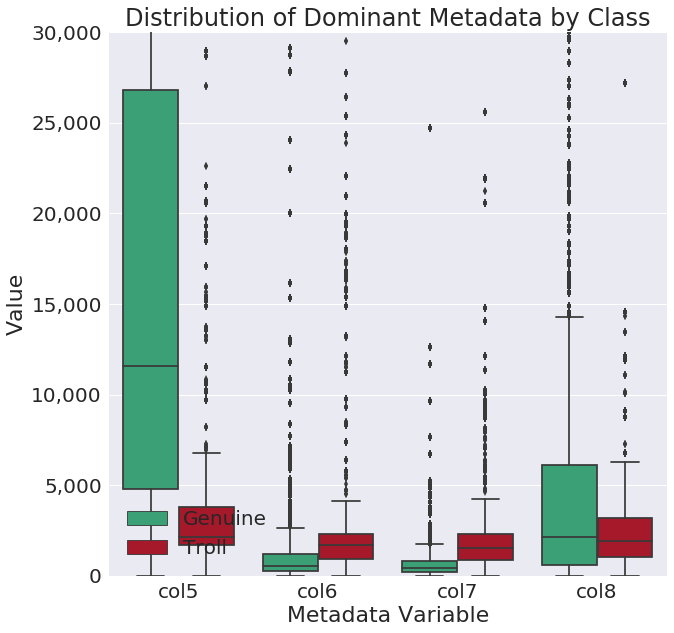

In [27]:
#Verify Metadata Columns with Graph:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='variable', y='value', hue='target', data=plot_data, palette=['#2bb179', '#be0119'])
plt.ylim(0, 30000)
ax.set_title('Distribution of Dominant Metadata by Class')
ax.set_xlabel('Metadata Variable')
ax.set_xticklabels(value_cols)
ax.set_ylabel('Value')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax.legend(labels=["A","B"])
L=plt.legend()
L.get_texts()[0].set_text('Genuine')
L.get_texts()[1].set_text('Troll')
sns.set(font_scale=1)

#Conclusion:  Yes, this plot verifies columns 5, 6, 7, and 8 are the correct columns to remove
#because their boxplots shapes are the same as those from the chart in the Exploration notebook.

In [28]:
#Remove some metadata columns (optional)

#For reference, if we want to remove columns, here is their order:

#Tweet Level
#0. retweet_count
#1. favorite_count
#2. num_hashtags
#3. num_urls
#4. num_mentions

#User Level
#5. statuses_count
#6. followers_count
#7. friends_count
#8. favourites_count
#9. listed_count

#Tweet Level (calculated)
#10. seq_len_cantok

remove_meta_cols = True
cols_to_remove = np.array([5, 6, 7, 8])
if remove_meta_cols:
    arr_metadata = np.delete(arr_metadata, obj=cols_to_remove, axis=1)

#Scale metadata columns
metadata = StandardScaler().fit_transform(arr_metadata)
meta_dim = metadata.shape[1]
print(metadata.shape)
print(meta_dim)
metadata

(2990987, 7)
7


array([[-0.04913827, -0.02927504,  2.23807761, ...,  0.29744285,
        -0.18353623, -0.43800918],
       [-0.04920022, -0.02927504, -0.35186432, ..., -0.84444135,
        -0.12139104, -0.43800918],
       [-0.04920022, -0.02927504, -0.35186432, ...,  0.29744285,
        -0.11183024, -1.29891315],
       ...,
       [-0.04920022, -0.02927504, -0.35186432, ...,  0.29744285,
         1.31272873, -1.19130015],
       [-0.04907633,  0.02292522, -0.35186432, ..., -0.84444135,
        -0.18831663, -0.65323517],
       [-0.04920022, -0.02927504, -0.35186432, ...,  0.29744285,
        -0.14529303, -1.08368716]])

In [29]:
meta_dim

7

## TensorFlow !

First, we'll build our model:

In [30]:
#Design the TF Model
tf.reset_default_graph() # fixes our reuse of variables problem

#Cutoffs for train, dev, test splits
2990987
cutoff_train_dev = 2900000
cutoff_dev_test = 2920000
cutoff_test_end = None
truncate_test_data = True  #Useful to keep data size small for testing
if truncate_test_data:
    cutoff_test_end = 2940000
    
#Model parameters
epoch = 20  #Pretty good after 10 (with batch size = 500)
batch_size = 10000
lrn_rate = 0.001  #Default is 0.001
ep = 1e-08  #Default is 1e-08
hidden_lstm_size = 32     #Research paper was 32
hidden_meta_h1_size = 128 #Research paper was 128
hidden_meta_h2_size = 64  #Research paper was 64


#Model inputs
data = tf.placeholder(tf.float32, [None, cutoff_length, 50])  #[batch_size, max_seq_length, num_features]
target = tf.placeholder(tf.float32, [None, 2])    #[batch_size, output_length = num_classes]
meta = tf.placeholder(tf.float32, [None, meta_dim])    #[batch_size, meta_dim]

#BEFORE: data [bs, 27, 50] --> LSTM [bs, 34] --> Softmax [bs, 2]
#AFTER:  data [bs, 27, 50] --> LSTM [bs, 34] --> meta [bs, 34+meta_dim] --> Softmax [bs, 2]

#LSTM Layer
seq_lens = tf.placeholder(tf.int32, [None])  #[batch_size]  #Sequence Lengths
cell = tf.nn.rnn_cell.LSTMCell(hidden_lstm_size,state_is_tuple=True)
val, state = tf.nn.dynamic_rnn(cell, data, sequence_length=seq_lens, dtype=tf.float32)

#Append metadata to LSTM end state (last) vector
#Remember, 'meta' is the tensor name, 'metadata' is the actual data we supply to feed_dict (when we execute below)
use_meta = True
if use_meta:
    meta_last = tf.concat([state[1], meta], axis=1)
else:
    meta_last = state[1]
    meta_dim = 0

#Post-LSTM Hidden Layer 1
weight_meta_h1 = tf.Variable(tf.truncated_normal([hidden_lstm_size + meta_dim, hidden_meta_h1_size]))  #[bs, 34+meta_dim, h1]
bias_meta_h1 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h1_size]))  #[bs, h1]
x_meta_h1 = tf.nn.relu(tf.matmul(meta_last, weight_meta_h1) + bias_meta_h1)

#Post-LSTM Hidden Layer 2
weight_meta_h2 = tf.Variable(tf.truncated_normal([hidden_meta_h1_size, hidden_meta_h2_size]))  #[bs, h1, h2]
bias_meta_h2 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h2_size]))  #[bs, h2]
#x_meta_h2 = tf.matmul(meta_last, weight_meta_h2) + bias_meta_h2
x_meta_h2 = tf.nn.relu(tf.matmul(x_meta_h1, weight_meta_h2) + bias_meta_h2)

#Softmax Layer (final output)
#Note the weight dimension changed from hidden_lstm_size to hidden_lstm_size + meta_dim
#If use_meta = False, change size of weight_final and input to prediction
weight_final = tf.Variable(tf.truncated_normal([hidden_meta_h2_size, int(target.get_shape()[1])]))  #[bs, hidden_meta_h1_size, 2]
bias_final = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))  #[bs, 2]
prediction = tf.nn.softmax(tf.matmul(x_meta_h2, weight_final) + bias_final)

#Loss Function
cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer(learning_rate=lrn_rate, epsilon=ep)
minimize = optimizer.minimize(cross_entropy)

mistakes = tf.not_equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

In [31]:
#Execute the model!
time_start = timeit.default_timer()

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

no_of_batches = int(cutoff_train_dev/batch_size)
status_every = 50
print("Number of batches: {}".format(no_of_batches))
for i in range(epoch):
    ptr = 0
    batch_num = 1
    for j in range(no_of_batches):
        batch_num+=1
        
        ##### BUILD THE EMBEDDINGS PER BATCH HERE #####
        #train_data [bs, 99.5pct_length, embed_dim] = [bs, 40, 50]
        #train_labels [bs, 2]
        #seq_lens_batch = [bs]
        #meta_inp = [bs, meta_dim] = [bs, 7 or 11]
        
        if j%status_every == 0:
            time_batch = timeit.default_timer()
            print('Processing batch {:,}.  Time elapsed: {:.0f} seconds'.format(j, time_batch - time_start))
        
        ######## LATER, PUT THESE DIRECTLY INTO THE FEED DICT ... THIS PART SEEMS WASTED #########
        inp = embed_batch(token_list[ptr:ptr+batch_size])
        out = targ_hot[ptr:ptr+batch_size]
        seq_lens_batch = sequence_lens[ptr:ptr+batch_size]
        meta_inp = metadata[ptr:ptr+batch_size]
        
        ptr+=batch_size
        #feed_dict format = {tensor_name: data, tensor_name2: data2, etc.}
        sess.run(
            minimize,
            feed_dict=
            {
                data: inp,
                target: out,
                seq_lens: seq_lens_batch,
                meta: meta_inp
            }
        )
    
    print("Epoch -", str(i + 1), end='')
    incorrect = sess.run(error, {data: embed_batch(token_list[cutoff_train_dev:cutoff_dev_test]), 
                                 target: targ_hot[cutoff_train_dev:cutoff_dev_test], 
                                 seq_lens: sequence_lens[cutoff_train_dev:cutoff_dev_test], 
                                 meta: metadata[cutoff_train_dev:cutoff_dev_test]
                                })    
    print(': Error = {:3.2f}%.  '.format(100 * incorrect), end='')
    
    #Timing
    time_epoch = timeit.default_timer()
    print('Time to train {} epoch(s): {:.0f} seconds'.format(i+1, time_epoch - time_start))

#Running this at the end to manually test accuracy
#Recall, preds is a softmax, so floats, not ints
print('Fetch numerous tensors for post hoc analysis ... ', end='')

preds, targs = \
    sess.run([prediction, target], 
             {data: embed_batch(token_list[cutoff_dev_test:cutoff_test_end]),
              target: targ_hot[cutoff_dev_test:cutoff_test_end],
              seq_lens: sequence_lens[cutoff_dev_test:cutoff_test_end],
              meta: metadata[cutoff_dev_test:cutoff_test_end]
             })
            
print('done!')

sess.close()

#Timing
time_end = timeit.default_timer()
print('Time to run cell: {:.0f} seconds'.format(time_end - time_start))

Number of batches: 290
Processing batch 0.  Time elapsed: 0 seconds
Processing batch 50.  Time elapsed: 76 seconds
Processing batch 100.  Time elapsed: 150 seconds
Processing batch 150.  Time elapsed: 224 seconds
Processing batch 200.  Time elapsed: 299 seconds
Processing batch 250.  Time elapsed: 373 seconds
Epoch - 1: Error = 6.92%.  Time to train 1 epoch(s): 433 seconds
Processing batch 0.  Time elapsed: 433 seconds
Processing batch 50.  Time elapsed: 508 seconds
Processing batch 100.  Time elapsed: 581 seconds
Processing batch 150.  Time elapsed: 655 seconds
Processing batch 200.  Time elapsed: 729 seconds
Processing batch 250.  Time elapsed: 803 seconds
Epoch - 2: Error = 3.07%.  Time to train 2 epoch(s): 863 seconds
Processing batch 0.  Time elapsed: 863 seconds
Processing batch 50.  Time elapsed: 937 seconds
Processing batch 100.  Time elapsed: 1011 seconds
Processing batch 150.  Time elapsed: 1085 seconds
Processing batch 200.  Time elapsed: 1159 seconds
Processing batch 250.  

## Results Analysis

In [32]:
#Manual accuracy check with test data!
test_range = cutoff_test_end - cutoff_dev_test
correct = 0
for i in range(test_range):
    if int(preds[i][0]+0.5) == int(targs[i][0]):
        correct += 1
        
print('Test Set Accuracy: {:.2%}, Error: {:.2%}'.format(correct / test_range, 1 - (correct / test_range) ))

Test Set Accuracy: 98.66%, Error: 1.34%


In [33]:
print('Genuine Tweets: {}'.format(cutoff_test_end - np.sum(arr_targetdata[0:cutoff_test_end]) ))
print('Troll Tweets: {}'.format(np.sum(arr_targetdata[0:cutoff_test_end])))

print(preds.shape)
print(targs.shape)
print(preds[0:5])
print(targs[0:5])

Genuine Tweets: 2739953
Troll Tweets: 200047
(20000, 2)
(20000, 2)
[[9.9212122e-01 7.8787524e-03]
 [1.0000000e+00 8.8117131e-09]
 [9.9983191e-01 1.6807513e-04]
 [9.9999499e-01 5.0598819e-06]
 [9.9758446e-01 2.4155015e-03]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
